# Análise de dados - Portal da Transparência

In [5]:
ano = 2022
caminho_dados = f'/content/drive/MyDrive/AD/{ano}_Viagem.csv'
caminho_saida_tabela = f'/content/drive/MyDrive/AD/output/tabela_{ano}.xlsx'
caminho_saida_grafico = f'/content/drive/MyDrive/AD/output/grafico_{ano}.png'

In [6]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Lendo os dados
df_viagens = pd.read_csv(caminho_dados, encoding='Windows-1252', sep=';', decimal=",")

# Criando nova coluna de despesas
df_viagens['Despesas'] = df_viagens['Valor diárias'] + df_viagens['Valor passagens'] + df_viagens['Valor outros gastos']

# Ajustando valores nulos na coluna de cargo
df_viagens['Cargo'] = df_viagens['Cargo'].fillna("NÃO IDENTIFICADO")

# Convertendo colunas de datas
df_viagens["Período - Data de início"] = pd.to_datetime(df_viagens["Período - Data de início"], format="%d/%m/%Y")
df_viagens["Período - Data de fim"] = pd.to_datetime(df_viagens["Período - Data de fim"], format="%d/%m/%Y")

# Criando novas colunas de datas
df_viagens['Mês da viagem'] = df_viagens['Período - Data de início'].dt.month_name()
df_viagens['Dias de viagem'] = (df_viagens['Período - Data de fim'] - df_viagens['Período - Data de início']).dt.days

In [7]:
# Criando tabela consolidada
df_viagens_consolidado = (df_viagens
 .groupby('Cargo')
 .agg(
    despesa_media=('Despesas', 'mean'),
    duracao_media=('Dias de viagem', 'mean'),
    despesas_totais=('Despesas', 'sum'),
    destino_mais_frequente=('Destinos', pd.Series.mode),
    n_viagens=('Nome', 'count')
    )
 .reset_index()
 .sort_values(by='despesas_totais', ascending=False))

# Filtrando tabela consolidada por cargos relevantes (> 1% das viagens)
df_cargos = df_viagens['Cargo'].value_counts(normalize=True).reset_index()
cargos_relevantes = df_cargos.loc[df_cargos['proportion'] > 0.01, 'Cargo']
filtro = df_viagens_consolidado['Cargo'].isin(cargos_relevantes)

# Chegando na tabela final - consolidada e filtrada!
df_final = df_viagens_consolidado[filtro].sort_values(by='n_viagens', ascending=False)

# Salvando a tabela final
df_final.to_excel(caminho_saida_tabela, index=False)

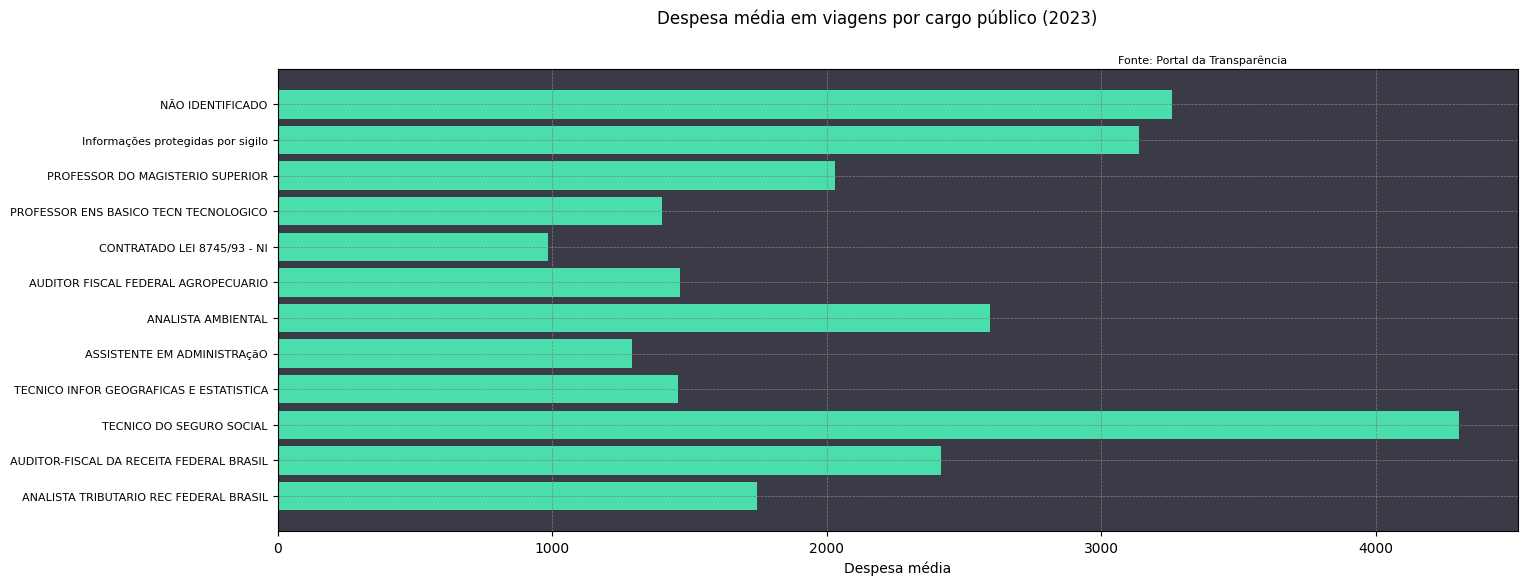

In [10]:
import matplotlib.pyplot as plt

# Criando a figura
fig, ax = plt.subplots(figsize=(16, 6))

# Plotando o gráfico
ax.barh(df_final['Cargo'], df_final['despesa_media'], color="#49deac")
ax.invert_yaxis()

# Ajustando o gráfico
ax.set_facecolor('#3b3b47')
fig.suptitle('Despesa média em viagens por cargo público (2023)')
plt.figtext(0.65, 0.89, 'Fonte: Portal da Transparência', fontsize=8)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.yticks(fontsize=8)
plt.xlabel('Despesa média')

# Salvando o gráfico
plt.savefig(caminho_saida_grafico, bbox_inches='tight')